In [72]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, DateFormatter
from statsmodels.tsa.seasonal import STL
from sklearn.preprocessing import LabelEncoder

Завантажимо всі дані і закодуємо категоріальні змінні Label Encoding щоб подивитись на кореляції в даних

In [81]:
# Завантаження даних
df = pd.read_excel('Data_Set_10.xls')

# Переводимо потрібні колонки в datetime
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%m.%d.%Y %H:%M:%S')
df['Ship Date'] = pd.to_datetime(df['Ship Date'], format='%m.%d.%Y %H:%M:%S')

# Список категоріальних колонок
categorical_columns = ['Category', 'Sub-Category', 'Region', 'City', 'State', 'Segment', 'Ship Mode']

# Створення словника для Label Encoding
label_encoders = {}

# Label Encoding категоріальних змінних
for column in categorical_columns:
    le = LabelEncoder()
    df[f'{column}_encoded'] = le.fit_transform(df[column])
    label_encoders[column] = le

Подивимось на статистичні дані про цільову колонку 'Sales'

count     9994.000000
mean       229.858001
std        623.245101
min          0.444000
25%         17.280000
50%         54.490000
75%        209.940000
max      22638.480000
Name: Sales, dtype: float64


{'whiskers': [<matplotlib.lines.Line2D at 0x13002f070>,
 'caps': [<matplotlib.lines.Line2D at 0x13002f850>,
 'boxes': [<matplotlib.lines.Line2D at 0x13002fee0>],
 'medians': [<matplotlib.lines.Line2D at 0x13002f8b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x12f641d30>],
 'means': []}

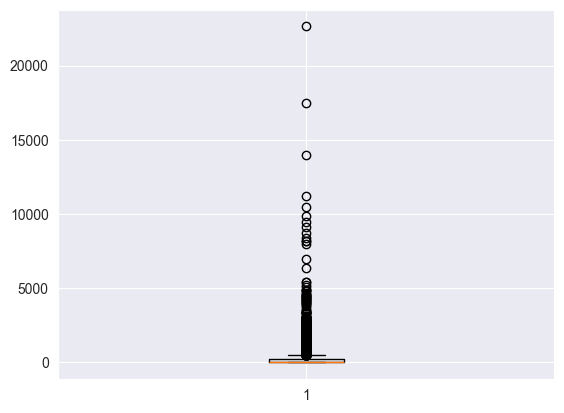

In [82]:
print(df['Sales'].describe())

plt.boxplot(df['Sales'])

Як ми бачимо з boxplot в датасеті багато викидів, можу припустити що це відбувається, бо магазин обслуговує і простих і корпоративних клієнтів, це може завадити навчанню моделі передбачення продажів.
Тепер створимо кореляційну матрицю і подивимось на результат:

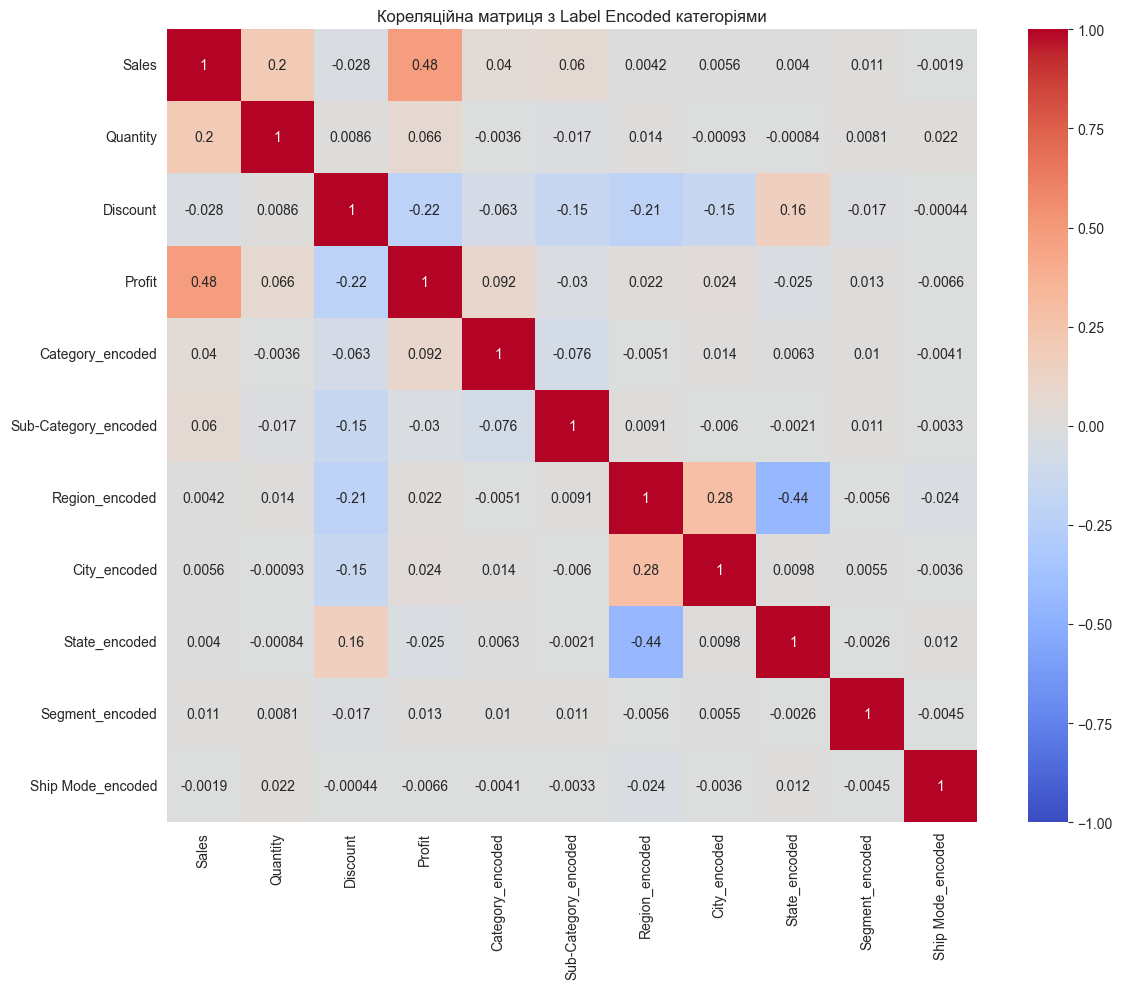


Кореляція з Sales:
Sales                   1.000000
Profit                  0.479064
Quantity                0.200795
Sub-Category_encoded    0.059843
Category_encoded        0.040077
Segment_encoded         0.010866
City_encoded            0.005592
Region_encoded          0.004216
State_encoded           0.004015
Ship Mode_encoded      -0.001887
Discount               -0.028190
Name: Sales, dtype: float64


In [83]:
# Створення масиву для кореляції
correlation_columns = ['Sales', 'Quantity', 'Discount', 'Profit'] + [f'{col}_encoded' for col in categorical_columns]

# Кореляційна матриця
correlation_matrix = df[correlation_columns].corr()

# Теплова карта кореляцій
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            center=0,
            vmin=-1,
            vmax=1)
plt.title('Кореляційна матриця з Label Encoded категоріями')
plt.tight_layout()
plt.show()

# Кореляція з Sales
sales_correlations = correlation_matrix['Sales'].sort_values(ascending=False)
print("\nКореляція з Sales:")
print(sales_correlations)

Як видно особливої кореляції між колонками і 'Sales' не видно, тепер проведемо аналіз часових рядів

In [96]:
# Так як в даних багато викидів(окремих замовлень на великі суми) то перед агрегацією спробуємо їх видалити
threshold = 6000
df = df[df['Sales'] < threshold].reset_index(drop=True)

# Агрегація даних по датах
df['Order Date'] = pd.to_datetime(df['Order Date'])
daily_sales = df.groupby('Order Date')['Sales'].sum().reset_index()
daily_sales = daily_sales.sort_values('Order Date')

Проведемо сезонну декомпозицію

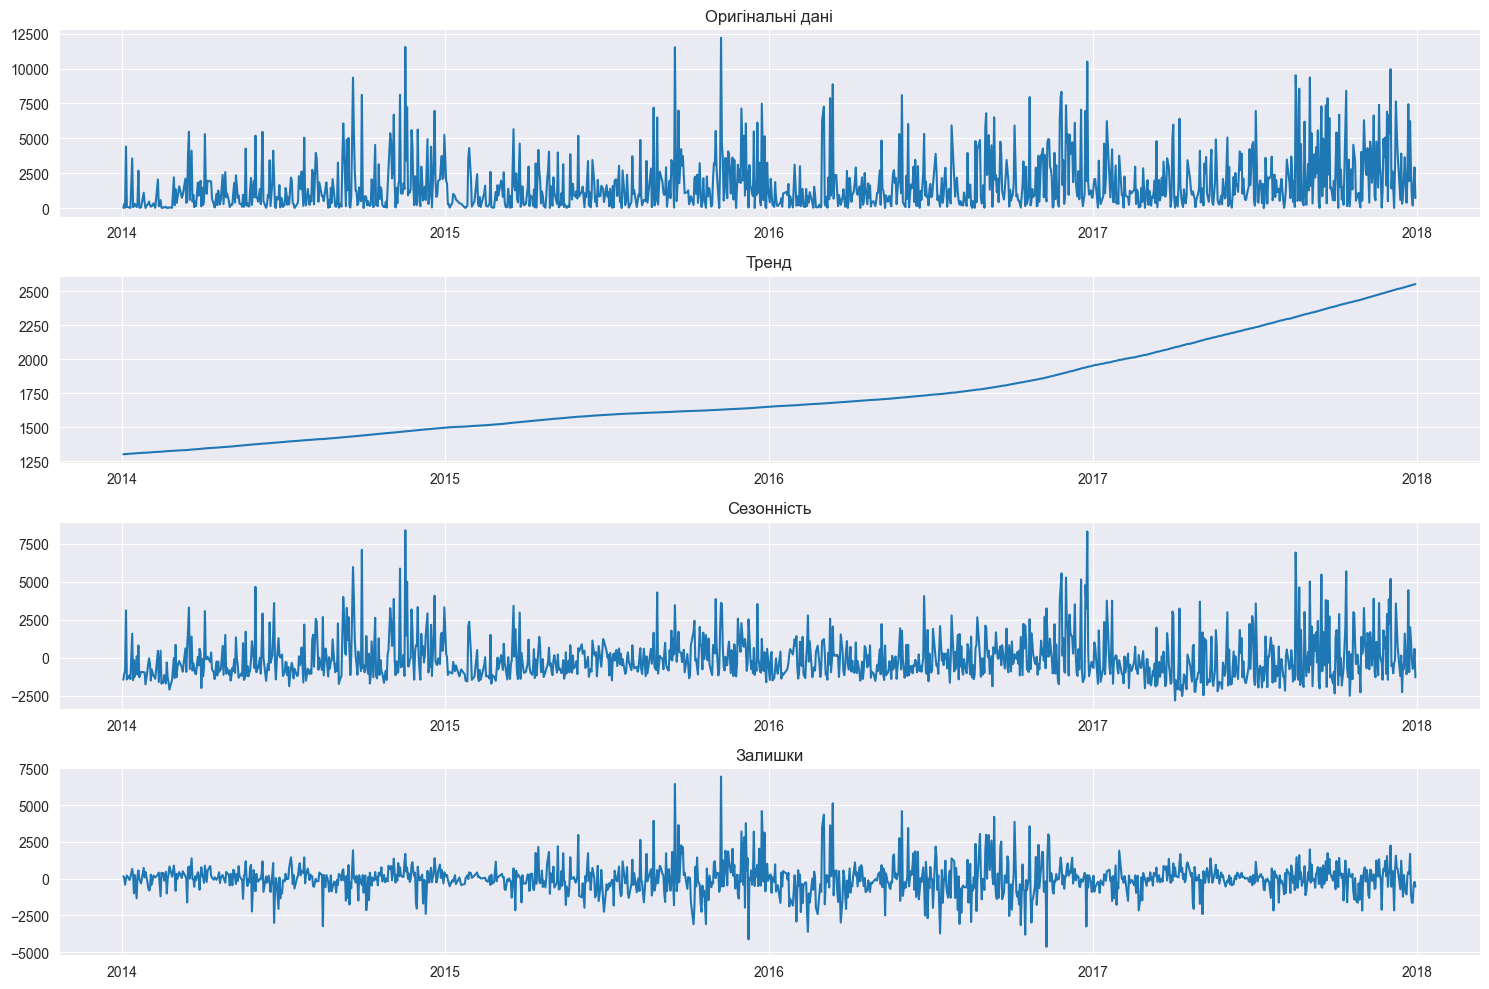

In [99]:
# Розклад часового ряду
stl = STL(daily_sales['Sales'], period=365, robust=False)
result = stl.fit()


# Додавання до датафрейму дані про сезонність, тренд і залишки
daily_sales['Trend'] = result.trend
daily_sales['Seasonal'] = result.seasonal
daily_sales['Residual'] = result.resid

# Виведемо всі отримані дані на графіках
plt.figure(figsize=(15,10))

plt.subplot(411)
plt.plot(daily_sales['Order Date'], daily_sales['Sales'])
plt.title('Оригінальні дані')
plt.gca().xaxis.set_major_locator(YearLocator(1))  # Роки через 1 рік(щоб по осі х виводився тільки рік)
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))  # Форматування як рік

plt.subplot(412)
plt.plot(daily_sales['Order Date'], result.trend)
plt.title('Тренд')
plt.gca().xaxis.set_major_locator(YearLocator(1))
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))

plt.subplot(413)
plt.plot(daily_sales['Order Date'], result.seasonal)
plt.title('Сезонність')
plt.gca().xaxis.set_major_locator(YearLocator(1))
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))

plt.subplot(414)
plt.plot(daily_sales['Order Date'], result.resid)
plt.title('Залишки')
plt.gca().xaxis.set_major_locator(YearLocator(1))
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))

plt.tight_layout()
plt.show()

Як видно з отриманих результатів, модель добре визначила тренд. Сезонність свідчить про те, що восени спостерігається підвищення обсягів продажів.
Залишки виглядають незвично: у період з середини 2015 року до кінця 2017 року їх розкид значно більший, ніж в інші періоди. Це може свідчити про можливу зміну бізнес-моделі магазину, переорієнтацію на іншу цільову аудиторію або виникнення нестабільності в продажах, враховуючи тренд у цей проміжок часу.
Далі перевіримо кореляцію між отриманими компонентами та показником Sales.

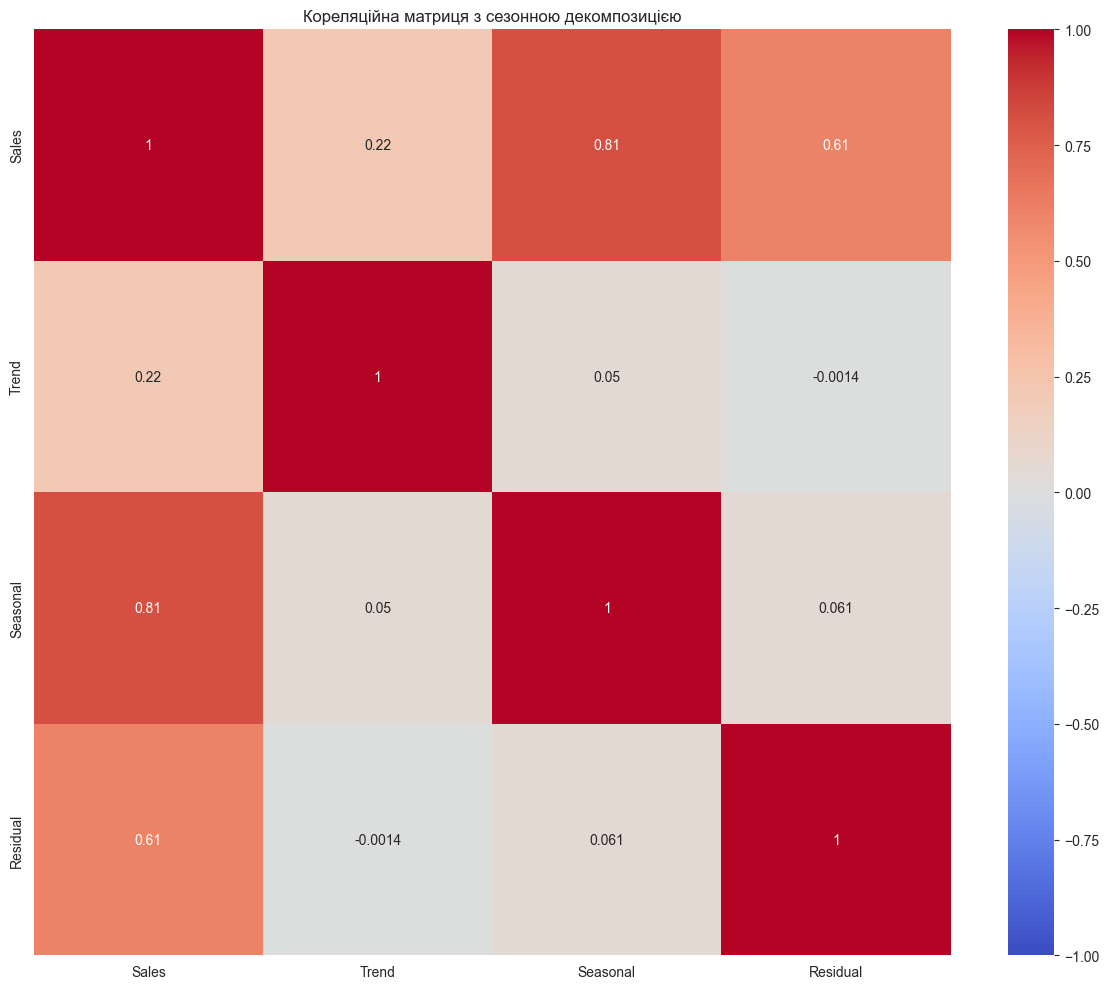


Кореляція з Sales:
Sales       1.000000
Seasonal    0.809110
Residual    0.608461
Trend       0.215101
Name: Sales, dtype: float64


In [100]:
# Створення масиву для кореляції
correlation_columns = ['Sales', 'Trend', 'Seasonal', 'Residual']

# Кореляційна матриця
correlation_matrix = daily_sales[correlation_columns].corr()

# Теплова карта кореляцій
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            center=0,
            vmin=-1,
            vmax=1)
plt.title('Кореляційна матриця з сезонною декомпозицією')
plt.tight_layout()
plt.show()

# Кореляція з Sales
sales_correlations = correlation_matrix['Sales'].sort_values(ascending=False)
print("\nКореляція з Sales:")
print(sales_correlations)

Кореляція з Sales показує, що сезонність (0.81) найбільше впливає на продажі, залишки (0.61) також містять частину інформації, а тренд (0.21) відображає лише довгострокові зміни.

Тепер додамо свята і дні для перевірки на кореляцію

In [101]:
# Додавання інформації про свята
import holidays

# Українські свята
ukr_holidays = holidays.US(years=daily_sales['Order Date'].dt.year.unique())

# Додавання стовпця свят
daily_sales['is_holiday'] = daily_sales['Order Date'].apply(lambda x: x in ukr_holidays)

# Додавання додаткових ознак
daily_sales['day_of_week'] = daily_sales['Order Date'].dt.dayofweek
daily_sales['month'] = daily_sales['Order Date'].dt.month
daily_sales['quarter'] = daily_sales['Order Date'].dt.quarter

Тепер додамо ковзне вікно і лаги для перевірки на кореляцію з Sales

In [118]:
# Ковзне вікно для обчислення додаткових ознак
def create_features(df):
    df['rolling_mean_7'] = df['Sales'].rolling(window=7).mean()
    df['rolling_std_7'] = df['Sales'].rolling(window=7).std()
    df['rolling_max_14'] = df['Sales'].rolling(window=14).max()
    df['rolling_min_14'] = df['Sales'].rolling(window=14).min()
    return df

daily_sales = create_features(daily_sales)

# Створення лаґових ознак
def create_lag_features(df, lags):
    for lag in lags:
        df[f'sales_lag_{lag}'] = df['Sales'].shift(lag)
    return df

daily_sales = create_lag_features(daily_sales, [1, 7, 14, 30])

Перевірямо на кореляцію свята, дні, місяці та чверті

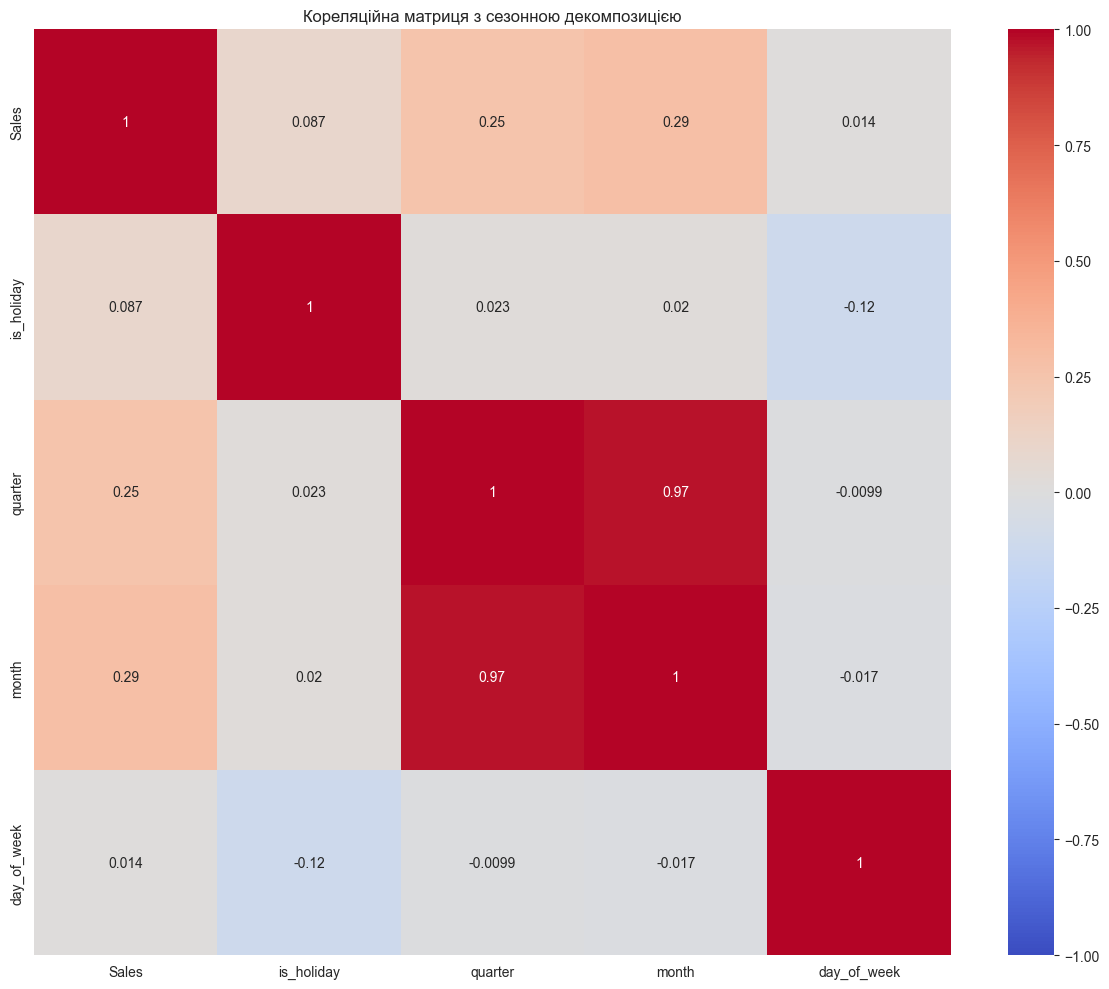


Кореляція з Sales:
Sales          1.000000
month          0.287200
quarter        0.252862
is_holiday     0.086925
day_of_week    0.014064
Name: Sales, dtype: float64


In [103]:
# Створення масиву для кореляції
correlation_columns = ['Sales', 'is_holiday', 'quarter', 'month', 'day_of_week']

# Кореляційна матриця
correlation_matrix = daily_sales[correlation_columns].corr()

# Теплова карта кореляцій
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            center=0,
            vmin=-1,
            vmax=1)
plt.title('Кореляційна матриця з святами та днями тижня')
plt.tight_layout()
plt.show()

# Кореляція з Sales
sales_correlations = correlation_matrix['Sales'].sort_values(ascending=False)
print("\nКореляція з Sales:")
print(sales_correlations)

Тепер перевіримо ковзні середні та лаги

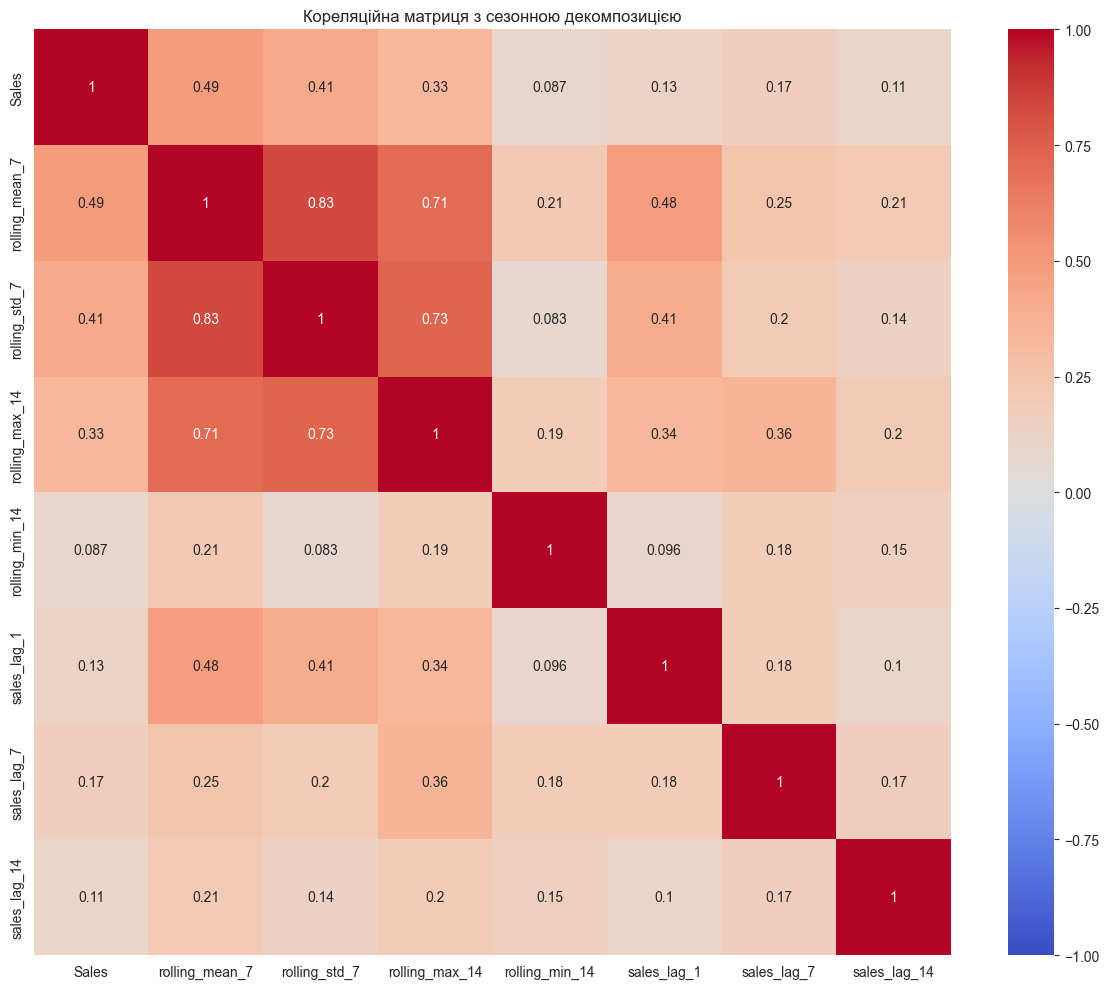


Кореляція з Sales:
Sales             1.000000
rolling_mean_7    0.491916
rolling_std_7     0.414202
rolling_max_14    0.329797
sales_lag_7       0.170316
sales_lag_1       0.127484
sales_lag_14      0.105664
rolling_min_14    0.087006
Name: Sales, dtype: float64


In [105]:
# Створення масиву для кореляції
correlation_columns = ['Sales', 'rolling_mean_7', 'rolling_std_7', 'rolling_max_14', 'rolling_min_14', 'sales_lag_1', 'sales_lag_7', 'sales_lag_14']

# Кореляційна матриця
correlation_matrix = daily_sales[correlation_columns].corr()

# Теплова карта кореляцій
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            center=0,
            vmin=-1,
            vmax=1)
plt.title('Кореляційна матриця з статистичними характеристиками')
plt.tight_layout()
plt.show()

# Кореляція з Sales
sales_correlations = correlation_matrix['Sales'].sort_values(ascending=False)
print("\nКореляція з Sales:")
print(sales_correlations)

Як видно з результатів висока кореляція між цільовою змінною і rolling_mean_7, rolling_std_7 та month, тоді як низька кореляція з is_holiday та лагами.
Для навчання моделі виберемо Seasonal, rolling_mean_7, rolling_std_7, month.
Тепер перевіримо змінні на мультиколінеарність (на кореляції між незалежними змінними)

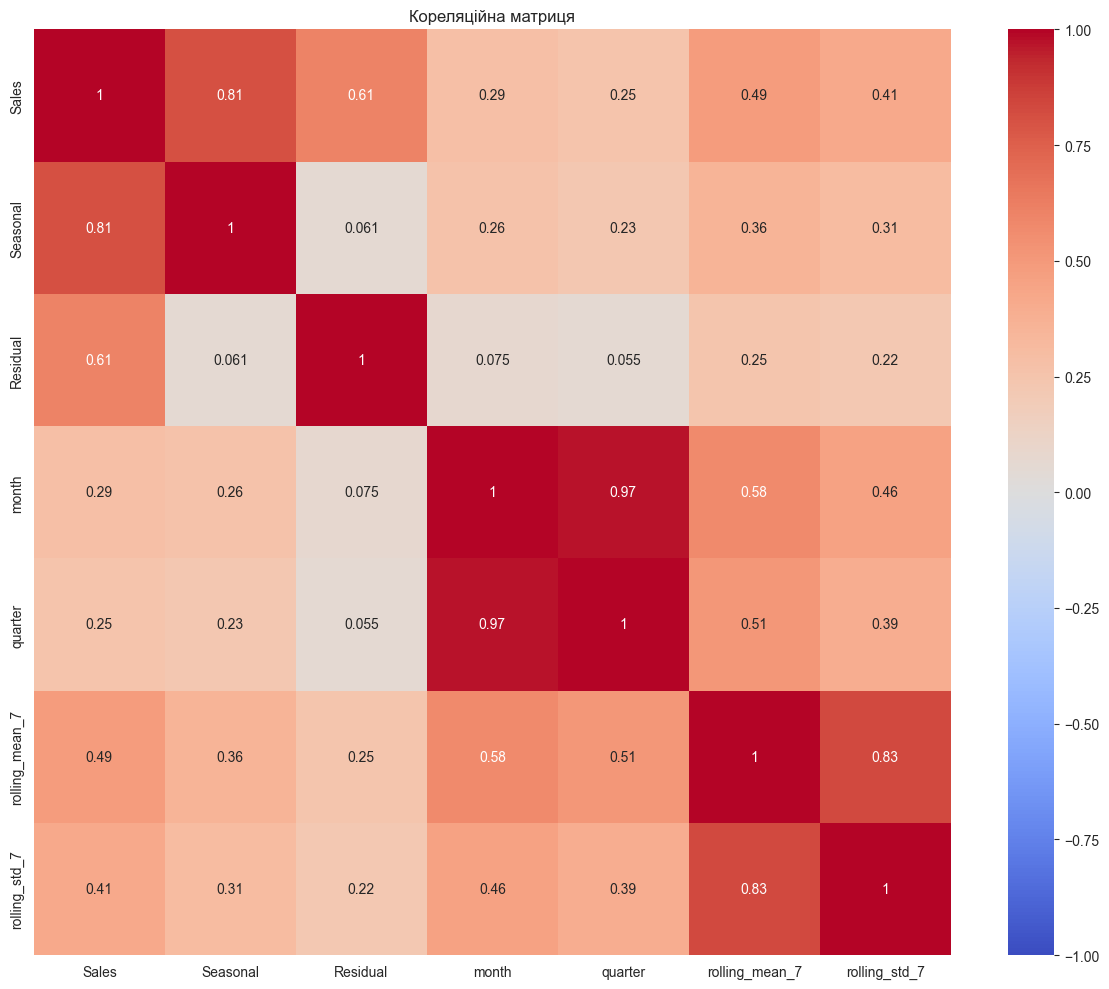


Кореляція з Sales:
Sales             1.000000
Seasonal          0.809110
Residual          0.608461
rolling_mean_7    0.491916
rolling_std_7     0.414202
month             0.287200
quarter           0.252862
Name: Sales, dtype: float64


In [111]:
target_columns = ['Sales', 'Seasonal', 'Residual', 'month', 'quarter', 'rolling_mean_7', 'rolling_std_7']

train_df = daily_sales[target_columns]

# Кореляційна матриця
correlation_matrix = train_df.corr()

# Теплова карта кореляцій
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            center=0,
            vmin=-1,
            vmax=1)
plt.title('Кореляційна матриця')
plt.tight_layout()
plt.show()

# Кореляція з Sales
sales_correlations = correlation_matrix['Sales'].sort_values(ascending=False)
print("\nКореляція з Sales:")
print(sales_correlations)

Як видно з heatmap всі змінні мають кореляцію між собою, остаточно виберемо для прогнозування колонки Seasonal, Residual, rolling_mean_7 та ще раз перевіримо на мультиколінеарність.

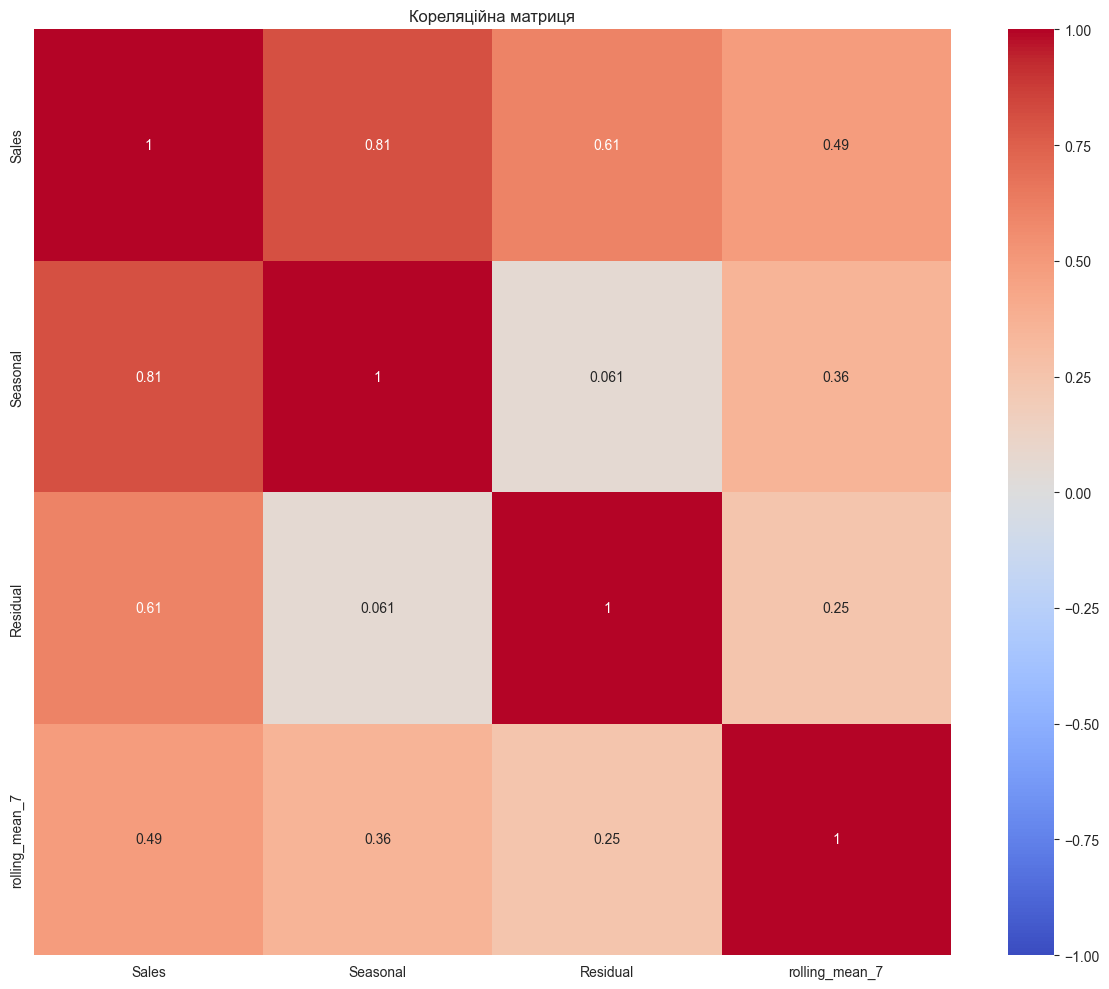

In [113]:
target_columns = ['Sales', 'Seasonal', 'Residual', 'rolling_mean_7']

train_df = daily_sales[target_columns]

# Кореляційна матриця
correlation_matrix = train_df.corr()

# Теплова карта кореляцій
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            center=0,
            vmin=-1,
            vmax=1)
plt.title('Кореляційна матриця')
plt.tight_layout()
plt.show()

Збережемо отриманий датафрейм daily_sales і використаємо його для навчання моделі

In [115]:
daily_sales.to_csv("DF_after_EDA.csv")